In [7]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
data = pd.read_excel('/Users/fabicampanari/Desktop/Regressão Logística/Exam_2-Logostic Regession/propensao doença.xlsx')

In [10]:
# Exibir as primeiras linhas do dataset
print("Visualização inicial dos dados:")
print(data.head())

Visualização inicial dos dados:
   Doença  Proteina1  Proteina2  Proteina3  Proteina4  Proteina5  Proteina6
0       1        0.8       0.83       0.66        1.9      1.100      0.996
1       1        0.9       0.36       0.32        1.4      0.740      0.992
2       0        0.8       0.88       0.70        0.8      0.176      0.982
3       0        1.0       0.87       0.87        0.7      1.053      0.986
4       1        0.9       0.75       0.68        1.3      0.519      0.980


In [11]:
# Passo 2: Pré-processamento dos dados
# Verificar valores ausentes
print("\nVerificando valores ausentes:")
print(data.isnull().sum())


Verificando valores ausentes:
Doença       0
Proteina1    0
Proteina2    0
Proteina3    0
Proteina4    0
Proteina5    0
Proteina6    0
dtype: int64


In [13]:
# Tratar valores ausentes (se houver)
if data.isnull().sum().sum() > 0:
    data = data.fillna(0)  # Substituir valores ausentes por 0 (ou outro método apropriado)

In [15]:
# Separar as variáveis independentes (X) e dependente (y)
X = data.drop('Doença', axis=1)  # Substitua 'Doença' pelo nome da variável dependente no arquivo
y = data['Doença']  # Variável dependente (incidência da doença)

In [16]:
# Adicionar uma constante para o intercepto
X = sm.add_constant(X)

In [18]:
# Passo 3: Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Passo 4: Ajustar o modelo de regressão logística inicial
model = sm.Logit(y_train, X_train).fit()

# Exibir o resumo do modelo inicial
print("\nResumo do Modelo Inicial:")
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.482917
         Iterations 9

Resumo do Modelo Inicial:
                           Logit Regression Results                           
Dep. Variable:                 Doença   No. Observations:                   21
Model:                          Logit   Df Residuals:                       14
Method:                           MLE   Df Model:                            6
Date:                Mon, 31 Mar 2025   Pseudo R-squ.:                  0.2733
Time:                        11:33:19   Log-Likelihood:                -10.141
converged:                       True   LL-Null:                       -13.955
Covariance Type:            nonrobust   LLR p-value:                    0.2667
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.4054     71.086      0.611      0.541     -95.920     182.731
Pr

In [58]:
# Passo 5: Aplicar o método Stepwise
# Função para aplicar o método stepwise
def stepwise_selection(X, y, initial_list=[], threshold_in=0.05, threshold_out=0.10):
    """
    Realiza a seleção de variáveis usando o método stepwise.
    """
    included = list(initial_list)
    while True:
        changed = False
        # Testar adição de novas variáveis
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.Logit(y, sm.add_constant(X[included + [new_column]])).fit(disp=0)
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True

        # Testar remoção de variáveis
        model = sm.Logit(y, sm.add_constant(X[included])).fit(disp=0)
        pvalues = model.pvalues.iloc[1:]  # Excluir a constante
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            changed = True

        if not changed:
            break
    return included

In [62]:
# Aplicar o método stepwise
selected_features = stepwise_selection(X_train, y_train)
print("\nVariáveis selecionadas pelo método Stepwise:")
print(selected_features)


Variáveis selecionadas pelo método Stepwise:
[]


In [65]:
# Ajustar o modelo final com as variáveis selecionadas
if not selected_features:  # Verificar se a lista de variáveis selecionadas está vazia
	print("Nenhuma variável foi selecionada. Usando todas as variáveis.")
	selected_features = X_train.columns.tolist()  # Usar todas as variáveis

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Ajustar o modelo final
model_final = sm.Logit(y_train, X_train_selected).fit()

Nenhuma variável foi selecionada. Usando todas as variáveis.
Optimization terminated successfully.
         Current function value: 0.482917
         Iterations 9


In [66]:
# Exibir o resumo do modelo final
print("\nResumo do Modelo Final:")
print(model_final.summary())


Resumo do Modelo Final:
                           Logit Regression Results                           
Dep. Variable:                 Doença   No. Observations:                   21
Model:                          Logit   Df Residuals:                       14
Method:                           MLE   Df Model:                            6
Date:                Mon, 31 Mar 2025   Pseudo R-squ.:                  0.2733
Time:                        11:46:49   Log-Likelihood:                -10.141
converged:                       True   LL-Null:                       -13.955
Covariance Type:            nonrobust   LLR p-value:                    0.2667
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.4054     71.086      0.611      0.541     -95.920     182.731
Proteina1     18.4344     44.327      0.416      0.678     -68.445     105.314
Proteina2     12.0716     5

In [67]:
# Exibir a equação do modelo final
print("\nEquação do Modelo Final:")
print(f"logit(P) = {model_final.params[0]:.4f} ", end="")
for i, (var, coef) in enumerate(model_final.params[1:].items(), start=1):
    print(f"+ ({coef:.4f} * {var}) ", end="")
print()


Equação do Modelo Final:
logit(P) = 43.4054 + (18.4344 * Proteina1) + (12.0716 * Proteina2) + (-12.4414 * Proteina3) + (3.2714 * Proteina4) + (-0.2183 * Proteina5) + (-65.3484 * Proteina6) 


/var/folders/sp/qr0jn46s10x5j0y77wb390d00000gn/T/ipykernel_16663/3857465752.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"logit(P) = {model_final.params[0]:.4f} ", end="")


In [68]:
# Passo 6: Avaliar a qualidade do ajuste do modelo
# Fazer previsões no conjunto de teste
y_pred = model_final.predict(X_test_selected)
y_pred_class = (y_pred > 0.5).astype(int)

In [ ]:
# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_class)
print("\nMatriz de Confusão:")
print(conf_matrix)

In [69]:

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_class))


Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         1

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



In [71]:
# Curva ROC e AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

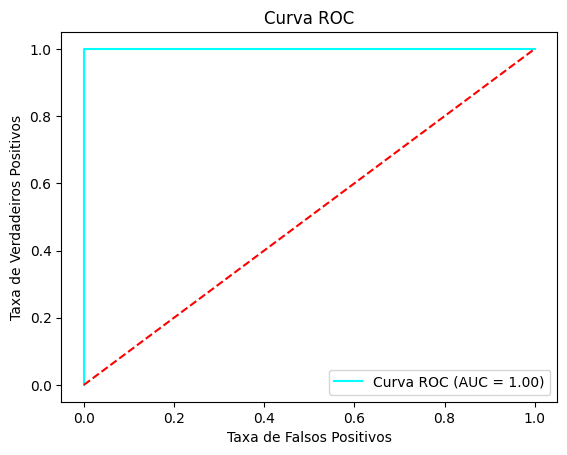

In [72]:
# Plotar a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='cyan', label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.style.use('dark_background')  # Tema dark mode
plt.show()